In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

###########################################################

from keras import models
from keras import layers
from keras import optimizers
#from keras import losses
from keras.layers.merge import concatenate
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, TensorBoard
from keras.applications import VGG16, ResNet50
import keras.backend as K

###########################################################

from ssd.generator import Generator
from ssd.data_augmenter import DataAugmenter
from ssd.bbox_codec import BBoxCodec, LargestObjClassCodec, LargestObjBoxCodec, LargestObjBoxAndClassCodec
from ssd.losses import SsdLoss, l1_loss, smooth_l1_loss, softmax_loss

import ssd.prior_box as pb
import ssd.imaging as imaging
import ssd.tools as tools
import ssd.data as data


Using TensorFlow backend.


In [3]:
################################################################################
voc_2012_base_dir = '../datasets/voc/VOCtrainval_11-May-2012/'
voc_2007_base_dir = '../datasets/voc/VOCtrainval_06-Nov-2007/'

use_voc_2012 = False#True

if use_voc_2012:
    voc_base_dir = voc_2012_base_dir 
    gtb_file = 'data/pascal_voc_2012.p'
else:
    voc_base_dir = voc_2007_base_dir 
    gtb_file = 'data/pascal_voc_2007.p'

img_dir = voc_base_dir + 'JPEGImages/'

target_img_size = (300, 300)
input_dim = (300, 300, 3)
num_classes = 21

batch_size=16
nb_epoch = 100#50
early_stopping_patience=5

################################################################################

# Load prepared GroundTruth boxes
gtb = pickle.load(open(gtb_file, 'rb'))

#img_file_names = shuffle(list(gtb.keys()))
#train_samples, valid_samples = train_test_split(img_file_names, test_size=0.1)

#train_samples =  data.load_samples_list(voc_base_dir + 'ImageSets/Main/train.txt')
#valid_samples =  data.load_samples_list(voc_base_dir + 'ImageSets/Main/val.txt')
train_val_samples = data.load_samples_list(voc_base_dir + 'ImageSets/Main/trainval.txt')
train_val_samples = shuffle(train_val_samples)
train_samples, valid_samples = train_test_split(train_val_samples, test_size=0.2)

# Degug using fitting tiny dataset
#img_file_names = list(gtb.keys())[:16] 
#train_samples, valid_samples = img_file_names[:14], img_file_names[14:]
#train_samples, valid_samples = [img_file_names[1]],[img_file_names[0]]

print('Train size: {0}'.format(len(train_samples)))
print('Valid size: {0}'.format(len(valid_samples)))

# calc # of samples per epoch
nb_samples_per_epoch = len(train_samples)
nb_valid_samples = len(valid_samples)

nb_steps_per_epoch = max(int(nb_samples_per_epoch/batch_size), 1)
nb_valid_steps_per_epoch = max(int(nb_valid_samples/batch_size), 1)

print('nb_steps_per_epoch: {0}'.format(nb_steps_per_epoch))
print('nb_valid_steps_per_epoch: {0}'.format(nb_valid_steps_per_epoch))

################################################################################

bbox_codec = LargestObjBoxAndClassCodec(code_type='coords')#code_type='center_size')
augmenter = DataAugmenter()
gen = Generator(gtb, img_dir, target_img_size, augmenter, bbox_codec)

# prepare train and valid generators
train_generator = gen.flow(train_samples, batch_size=batch_size, do_augment=True)
valid_generator = gen.flow(valid_samples, batch_size=batch_size, do_augment=True)


################################################################################

Train size: 4008
Valid size: 1003
nb_steps_per_epoch: 250
nb_valid_steps_per_epoch: 62


In [4]:
img_2012_dir = voc_2012_base_dir + 'JPEGImages/'

test_files = ['2007_000032.jpg', '2007_000256.jpg', '2007_000464.jpg', '2007_002462.jpg',
               '2007_002953.jpg', '2007_001149.jpg', '2007_001558.jpg', '2007_002088.jpg', '2007_003143.jpg',
             '2011_001771.jpg']

In [5]:
def one_detect_loss(y_true, y_pred):
    """
    y_true[:, 0:4] - encoded GTB loc
    y_true[:, 4:4+num_classes] - ground truth one-hot-encoding classes
    """
    loc_loss = smooth_l1_loss(y_true[:, :4], y_pred[:, :4])
    conf_loss = softmax_loss(y_true[:, 4:], y_pred[:, 4:])
    return loc_loss + conf_loss

# ResNet 50

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 300, 300, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 150, 150, 64)  9472        input_2[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 150, 150, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_51 (Activation)       (None, 150, 150, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

Epoch 1/100
250/250 [==============================] - 155s - loss: 7.5582 - val_loss: 4.4216
Epoch 2/100
250/250 [==============================] - 146s - loss: 5.3988 - val_loss: 3.6860
Epoch 3/100
250/250 [==============================] - 145s - loss: 4.4030 - val_loss: 1.9724
Epoch 4/100
250/250 [==============================] - 144s - loss: 3.8412 - val_loss: 1.4112
Epoch 5/100
250/250 [==============================] - 146s - loss: 3.3406 - val_loss: 1.1873
Epoch 6/100
250/250 [==============================] - 146s - loss: 2.9755 - val_loss: 1.0851
Epoch 7/100
250/250 [==============================] - 145s - loss: 2.6703 - val_loss: 1.0583
Epoch 8/100
250/250 [==============================] - 146s - loss: 2.3785 - val_loss: 0.9758
Epoch 9/100
250/250 [==============================] - 145s - loss: 2.1709 - val_loss: 0.8602
Epoch 10/100
250/250 [==============================] - 145s - loss: 2.0059 - val_loss: 0.8885
Epoch 11/100
250/250 [==============================] - 147

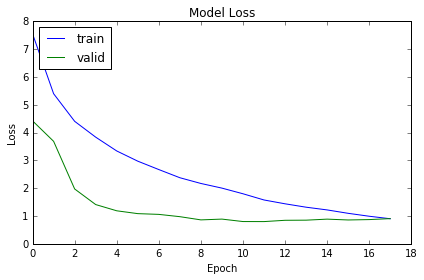

In [11]:
#K.clear_session()

base_net_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=input_dim)
tools.freeze_model(base_net_model1, 'res5c_branch2a')
    
x = layers.Flatten()(base_net_model1.output)
x = layers.Activation(activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

loc_layer = layers.Dense(4, name='loc')(x)
conf_layer = layers.Dense(num_classes, activation='softmax', name='conf')(x)
pred_layer = concatenate([loc_layer, conf_layer], name='pred')
model1 = models.Model(inputs=base_net_model1.input, outputs=pred_layer)

#base_net_model1.summary()
model1.summary()

model1.compile(optimizer=optimizers.Adam(lr=1e-4), loss=one_detect_loss)

model1_save_path='models/one-detect-resnet50-voc-2007-coords.h5'
model1_checkpoint = ModelCheckpoint(model1_save_path, monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto')
model1_early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, verbose=1, mode='auto')

history1 = model1.fit_generator(train_generator, steps_per_epoch=nb_steps_per_epoch,
                              validation_data=valid_generator, validation_steps=nb_valid_steps_per_epoch,
                              callbacks=[model1_checkpoint, model1_early_stopping],
                              epochs=nb_epoch,
                              )
#model1.save_weights('models/one-detect-resnet50-voc-2007-coords.h5')

tools.plot_loss(history1)

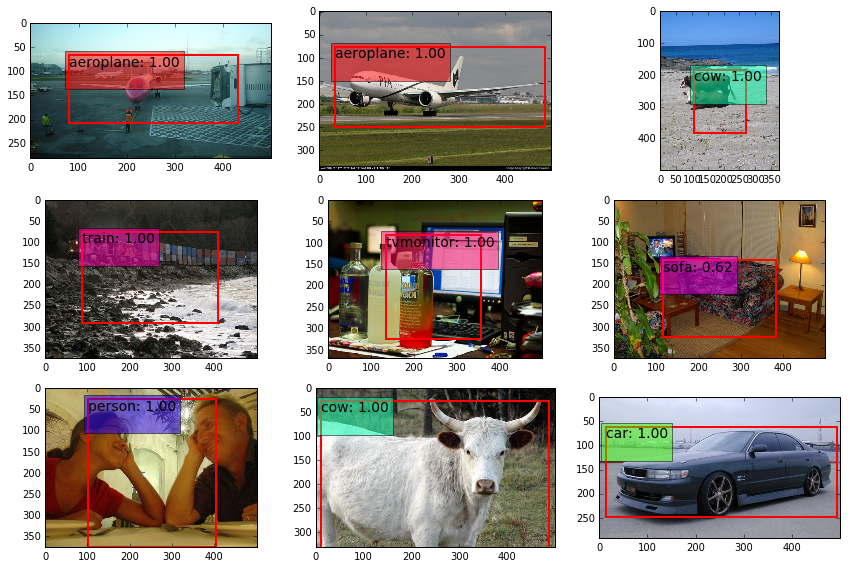

In [10]:
model1.load_weights('models/one-detect-resnet50-voc-2007-coords-80-iter.h5')
test_images, x_test, y_pred = tools.make_prediction(model1, target_img_size, img_2012_dir, test_files)
tools.show_predictions(test_images, y_pred, num_classes, cols=3)

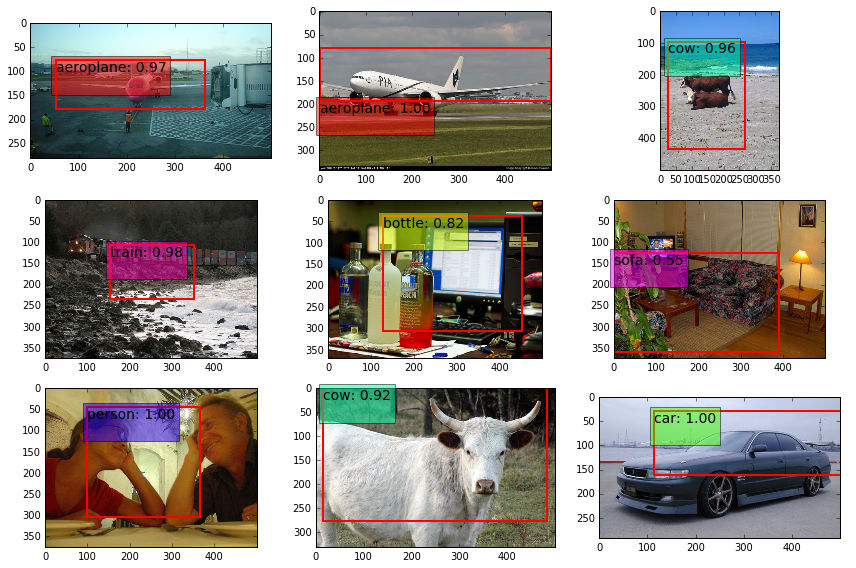

In [12]:
model1.load_weights('models/one-detect-resnet50-voc-2007-coords.h5')
test_images, x_test, y_pred = tools.make_prediction(model1, target_img_size, img_2012_dir, test_files)
tools.show_predictions(test_images, y_pred, num_classes, cols=3)

# VGG16

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 300, 300, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 300, 300, 64)  1792        input_3[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 300, 300, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 150, 150, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

250/250 [==============================] - 170s - loss: 2.2374 - val_loss: 1.4580
Epoch 9/100
250/250 [==============================] - 171s - loss: 2.0395 - val_loss: 1.5495
Epoch 10/100
250/250 [==============================] - 171s - loss: 1.8743 - val_loss: 1.3410
Epoch 11/100
250/250 [==============================] - 170s - loss: 1.6834 - val_loss: 1.3127
Epoch 12/100
250/250 [==============================] - 170s - loss: 1.5788 - val_loss: 1.4018
Epoch 13/100
250/250 [==============================] - 172s - loss: 1.4049 - val_loss: 1.2084
Epoch 14/100
250/250 [==============================] - 171s - loss: 1.2495 - val_loss: 1.2000
Epoch 15/100
250/250 [==============================] - 170s - loss: 1.1016 - val_loss: 1.3423
Epoch 16/100
250/250 [==============================] - 171s - loss: 0.9987 - val_loss: 1.2518
Epoch 17/100
250/250 [==============================] - 171s - loss: 0.9156 - val_loss: 1.1986
Epoch 18/100
250/250 [==============================] - 171s - l

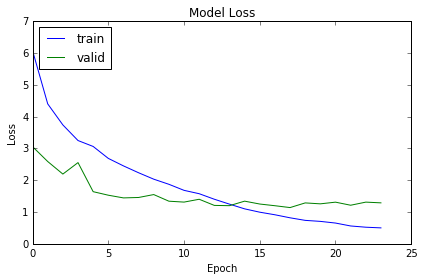

In [13]:
base_net_model2 = VGG16(weights='imagenet', include_top=False, input_shape=input_dim)
tools.freeze_model(base_net_model2, 'block5_conv1')
    
x = layers.Flatten()(base_net_model2.output)
x = layers.Activation(activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

loc_layer = layers.Dense(4, name='loc')(x)
conf_layer = layers.Dense(num_classes, activation='softmax', name='conf')(x)
pred_layer = concatenate([loc_layer, conf_layer], name='pred')
model2 = models.Model(inputs=base_net_model2.input, outputs=pred_layer)

#base_net_model2.summary()
model2.summary()

# Adam with 1e-3 stucks and the model can't learn at all
model2.compile(optimizer=optimizers.Adam(lr=1e-4), loss=one_detect_loss)

model2_save_path='models/one-detect-vgg16-voc-2007-coords.h5'
model2_checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto')
model2_early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, verbose=1, mode='auto')

history2 = model2.fit_generator(train_generator, steps_per_epoch=nb_steps_per_epoch,
                              validation_data=valid_generator, validation_steps=nb_valid_steps_per_epoch,
                              callbacks=[model2_checkpoint, model2_early_stopping],
                              epochs=nb_epoch,
                              )

#model2.save_weights('models/one-detect-vgg16-voc-2007-coords.h5')

tools.plot_loss(history2)

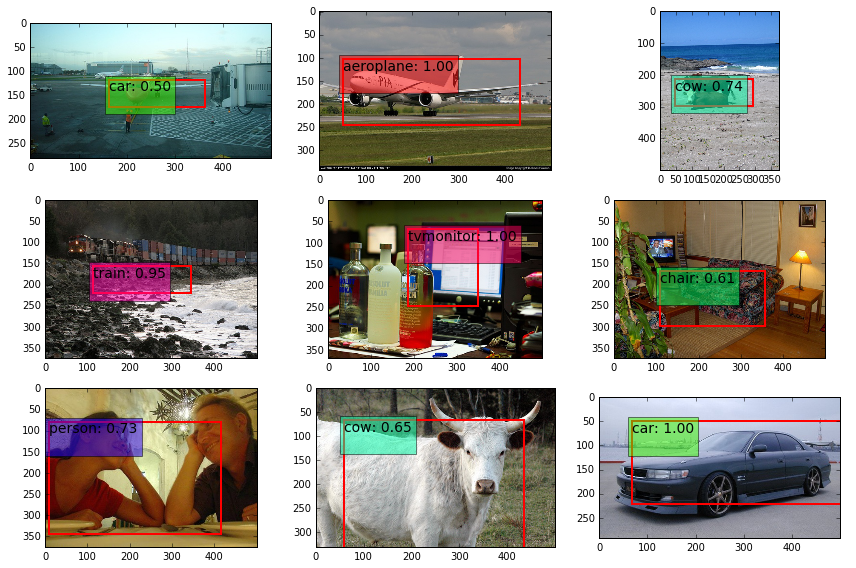

In [14]:
model2.load_weights('models/one-detect-vgg16-voc-2007-coords.h5')
test_images2, x_test2, y_pred2 = tools.make_prediction(model2, target_img_size, img_2012_dir, test_files)
tools.show_predictions(test_images2, y_pred2, num_classes, cols=3)

## Losses ResNet50 vs VGG16

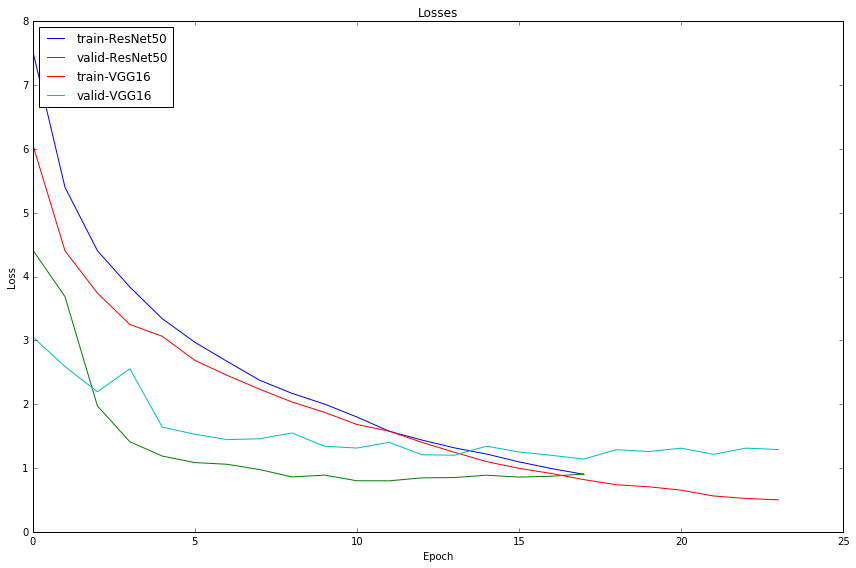

In [31]:
tools.plot_losses([history1, history2], ['ResNet50', 'VGG16'])